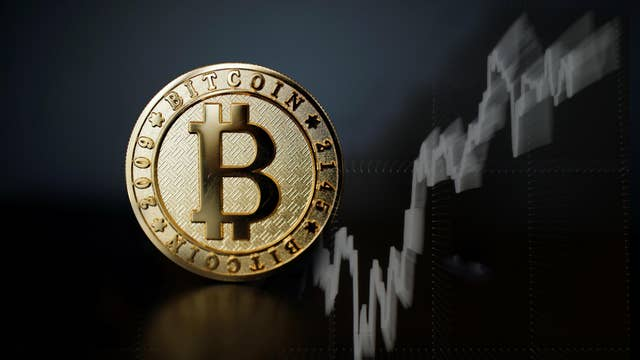

***Welcome to this notebook!***

Feel free to fork for your own learning and edit the code or use in your own submissions. If you found this notebook enriched and helps improving your learning in the slightest, please ***Upvote*** this notebook as an encouragement for me to continue writing notebooks! :)

# Table of Contents

* [Introduction](#section-one)
    - [First look](#subsection-one)
* [Handling Missing Values](#section-two)
* [Exploratory Data Analysis](#section-three)
    - [Lag Plots](#subsection-two)
    - [Time Resampling](#subsection-three)
* [Time Series Decomposition & Statistical Tests](#section-four)
    - [KPSS Test](#subsection-four)
    - [ADF Test](#subsection-five)
* [Feature Extraction](#section-five)
* [Model Building](#section-six)
    - [ARIMA](#subsection-six)
    - [FB Prophet](#subsection-seven)
    - [XG Boost](#subsection-eight)
    - [LSTM](#subsection-nine)
* [Model Selection](#section-seven)
* [Next Steps](#section-eight)

 <a id="section-one"></a>
# Introduction 

The first Bitcoin protocol and proof of concept was published in a Whitepaper in 2009 by a shadowy individual or group under the pseudonym Satoshi Nakamoto. Nakamoto, left the project in late 2010. Other developers took over and the Bitcoin community has since grown exponentially.

Bitcoin emerged out of the 2008 global economic crisis when big banks were caught misusing borrowers' money, manipulating the system, and charging exorbitant fees. To address such issues, Bitcoin creators wanted to put the owners of bitcoins in-charge of the transactions, eliminate the middleman, cut high interest rates and transaction fees, and make transactions transparent. They created a distributed network system, where people could control their funds in a transparent way.

However, there are issues with bitcoins such as hackers breaking into accounts, high volatility of bitcoins, and long transaction delays. Considering the volatility it's always challenging to predict the bitcoin price. 

In this notebook, we will be deep diving into the dataset, perform some EDA, feature engineering and will predict bitcoin price using Stochastic, Machine Learning and Deep Learning models. 

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import plotly.express as px
from itertools import product
import warnings
import statsmodels.api as sm
plt.style.use('seaborn-darkgrid')

#matplotlib inline

/tmp/ipykernel_55519/216109662.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


<a id="subsection-one"></a>
# A first look at Bitcoin Prices

Let’s check what the first 5 lines of our time-series data look like:

In [5]:
# Reading the csv file
bitstamp = pd.read_csv("../dataset.csv")
bitstamp.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let us now look at the datatypes of the various components.

In [6]:
bitstamp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


It appears that the Timestamp column is being treated as a integer rather than as dates. To fix this, we’ll use the fromtimestamp() function which converts the arguments to dates.

In [7]:
# Converting the Timestamp column from string to datetime
bitstamp['Timestamp'] = [datetime.fromtimestamp(x) for x in bitstamp['Timestamp']]

In [8]:

bitstamp.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 02:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,2011-12-31 02:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-12-31 02:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-12-31 02:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-12-31 02:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
print('Dataset Shape: ',  bitstamp.shape)

Dataset Shape:  (4857377, 8)


# About the Bitcoin Data¶

Included here is historical bitcoin market data at 1-min intervals for select bitcoin exchanges where trading takes place. It consists time period of Jan 2012 to September 2020, with minute to minute updates of OHLC (Open, High, Low, Close), Volume in BTC and indicated currency, and weighted bitcoin price. 

Now that our data has been converted into the desired format, let’s take a look at its various columns for further analysis.

* The **Open and Close** columns indicate the opening and closing price on a particular day.
* The **High and Low** columns provide the highest and the lowest price on a particular day, respectively.
* The **Volume** column tells us the total volume of traded on a particular day.
* The **Weighted price** is a trading benchmark used by traders that gives the weighted price a security has traded at throughout the day, based on both volume and price. It is important because it provides traders with insight into both the trend and value of a security. To read more about how Weighted price is calculated, click [here](http://bitcointalk.org/index.php?topic=2777198.0). 

# Visualising the Time Series data

<Axes: title={'center': 'Bitcoin Weighted Price'}, xlabel='Timestamp'>

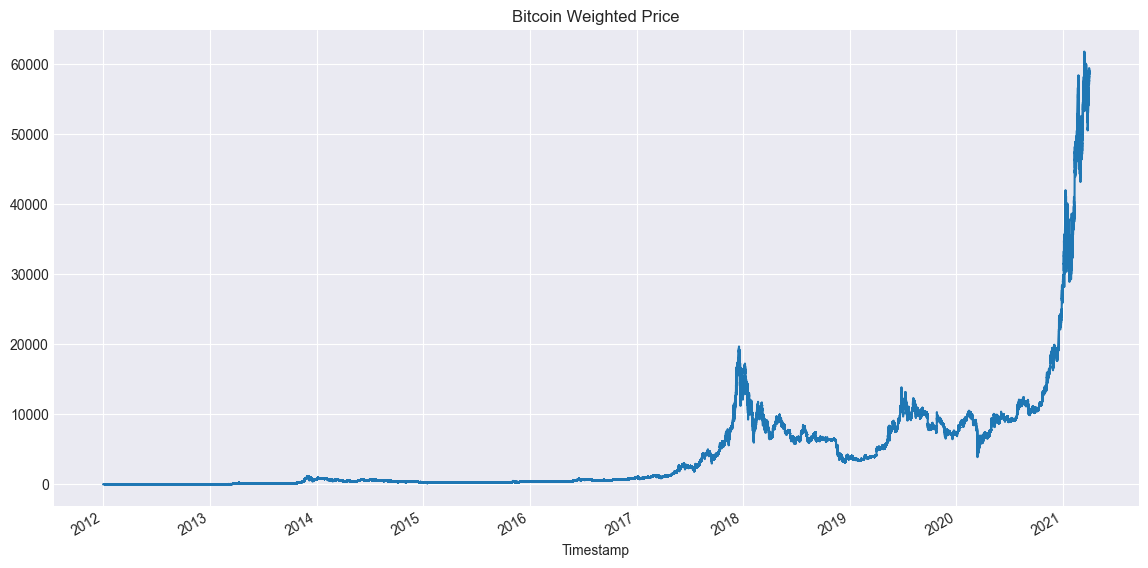

In [10]:
bitstamp.set_index("Timestamp").Weighted_Price.plot(figsize=(14,7), title="Bitcoin Weighted Price")

<a id="section-two"></a>
# Handling Missing Values in Time-series Data

It is very common for a time-series data to have missing data. The first step is to detect the count/percentage of missing values in every column of the dataset. This will give an idea about the distribution of missing values. Let's check this in our dataset:

In [11]:
#calculating missing values in the dataset

missing_values = bitstamp.isnull().sum()
missing_per = (missing_values/bitstamp.shape[0])*100
missing_table = pd.concat([missing_values,missing_per], axis=1, ignore_index=True) 
missing_table.rename(columns={0:'Total Missing Values',1:'Missing %'}, inplace=True)
missing_table

,Total Missing Values,Missing %
Timestamp,0,0.00000
Open,1243608,25.60246
High,1243608,25.60246
Low,1243608,25.60246
Close,1243608,25.60246
Volume_(BTC),1243608,25.60246
Volume_(Currency),1243608,25.60246
Weighted_Price,1243608,25.60246


# Imputations Techniques for non Time Series Problems

Imputation refers to replacing missing data with substituted values.There are a lot of ways in which the missing values can be imputed depending upon the nature of the problem and data. Dependng upon the nature of the problem, imputation techniques can be broadly they can be classified as follows:

**Basic Imputation Techniques**
* 'ffill' or 'pad' - Replace NaNs with last observed value
* 'bfill' or 'backfill' - Replace NaNs with next observed value
*  Linear interpolation method

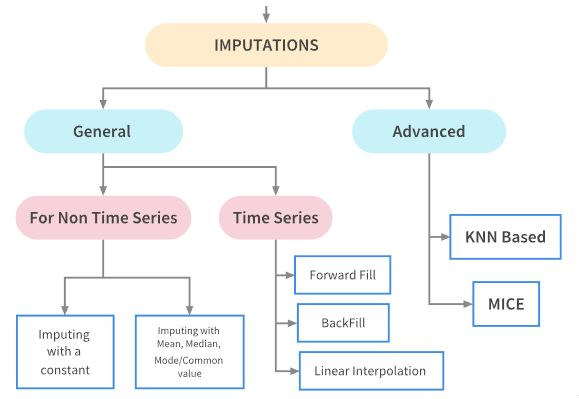

Let's sense check above stated 3 techniques on a subset to compare the output:

In [12]:
#testing missing value methods on a subset

pd.set_option('display.max_rows', 1500)

a = bitstamp.set_index('Timestamp')

a = a['2019-11-01 00:15:00':'2019-11-01 02:24:00']

a['ffill'] = a['Weighted_Price'].fillna(method='ffill') # Imputation using ffill/pad
a['bfill'] = a['Weighted_Price'].fillna(method='bfill') # Imputation using bfill/pad
a['interp'] = a['Weighted_Price'].interpolate()         # Imputation using interpolation

a

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,ffill,bfill,interp
Timestamp,,,,,,,,,,
2019-11-01 00:15:00,9064.83,9074.18,9064.83,9066.16,0.853061,7739.012571,9072.045831,9072.045831,9072.045831,9072.045831
2019-11-01 00:16:00,9066.49,9079.15,9066.49,9071.72,0.150835,1368.712953,9074.214482,9074.214482,9074.214482,9074.214482
2019-11-01 00:17:00,9073.47,9078.44,9073.47,9077.20,0.098682,895.562995,9075.275664,9075.275664,9075.275664,9075.275664
2019-11-01 00:18:00,9080.15,9086.57,9080.15,9086.57,8.241702,74876.216657,9085.042664,9085.042664,9085.042664,9085.042664
2019-11-01 00:19:00,9086.57,9086.70,9082.04,9086.70,4.986860,45313.430173,9086.564836,9086.564836,9086.564836,9086.564836
2019-11-01 00:20:00,9087.74,9092.66,9087.74,9090.07,5.019756,45629.905328,9090.064657,9090.064657,9090.064657,9090.064657
2019-11-01 00:21:00,9086.71,9097.85,9086.71,9086.77,1.406519,12791.748556,9094.612567,9094.612567,9094.612567,9094.612567
2019-11-01 00:22:00,9086.77,9086.77,9086.71,9086.71,0.128635,1168.867540,9086.718890,9086.718890,9086.718890,9086.718890
2019-11-01 00:23:00,9086.71,9091.70,9086.71,9086.74,0.062680,569.572956,9087.002538,9087.002538,9087.002538,9087.002538


**Imputation using Linear Interpolation method**

Time series data has a lot of variations against time. Hence, imputing using backfill and forward fill isn't the best possible solution to address the missing value problem. A more apt alternative would be to use interpolation methods, where the values are filled with incrementing or decrementing values.

[Linear interpolation](https://www.lexjansen.com/nesug/nesug01/ps/ps8026.pdf) is an imputation technique that assumes a linear relationship between data points and utilises non-missing values from adjacent data points to compute a value for a missing data point.

Refer to the official documentation for a complete list of interpolation strategies [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html)

In our dataset, we will be performing Linear interpolation on the missing value columns.

In [13]:
def fill_missing(df):
    ### function to impute missing values using interpolation ###
    df['Open'] = df['Open'].interpolate()
    df['Close'] = df['Close'].interpolate()
    df['Weighted_Price'] = df['Weighted_Price'].interpolate()

    df['Volume_(BTC)'] = df['Volume_(BTC)'].interpolate()
    df['Volume_(Currency)'] = df['Volume_(Currency)'].interpolate()
    df['High'] = df['High'].interpolate()
    df['Low'] = df['Low'].interpolate()

    print(df.head())
    print(df.isnull().sum())

In [14]:
fill_missing(bitstamp)

            Timestamp  Open  High   Low  Close  Volume_(BTC)  \
0 2011-12-31 02:52:00  4.39  4.39  4.39   4.39      0.455581   
1 2011-12-31 02:53:00  4.39  4.39  4.39   4.39      0.555046   
2 2011-12-31 02:54:00  4.39  4.39  4.39   4.39      0.654511   
3 2011-12-31 02:55:00  4.39  4.39  4.39   4.39      0.753977   
4 2011-12-31 02:56:00  4.39  4.39  4.39   4.39      0.853442   

   Volume_(Currency)  Weighted_Price  
0           2.000000            4.39  
1           2.436653            4.39  
2           2.873305            4.39  
3           3.309958            4.39  
4           3.746611            4.39  
Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64


No Null values in the final output. Now we will move to **Exploratory Data Analysis**.

First, we will create a copy of the dataset as in the next step we will be setting index as our Timestamp column. Its main advatange is to be able to query the datset fast and also helps in quering and filtering the dataset. Also, a lot of plots require our dataset to be indexed.

In [15]:
#created a copy 
bitstamp_non_indexed = bitstamp.copy()

In [16]:
bitstamp = bitstamp.set_index('Timestamp')
bitstamp.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 02:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.39
2011-12-31 02:53:00,4.39,4.39,4.39,4.39,0.555046,2.436653,4.39
2011-12-31 02:54:00,4.39,4.39,4.39,4.39,0.654511,2.873305,4.39
2011-12-31 02:55:00,4.39,4.39,4.39,4.39,0.753977,3.309958,4.39
2011-12-31 02:56:00,4.39,4.39,4.39,4.39,0.853442,3.746611,4.39


<a id="section-three"></a>

# Exploratory Data Analysis

**Visualizing the weighted price using markers**

When working with time-series data, a lot can be revealed through visualizing it.
It is possible to add markers in the plot to help emphasize the specific observations or specific events in the time series.

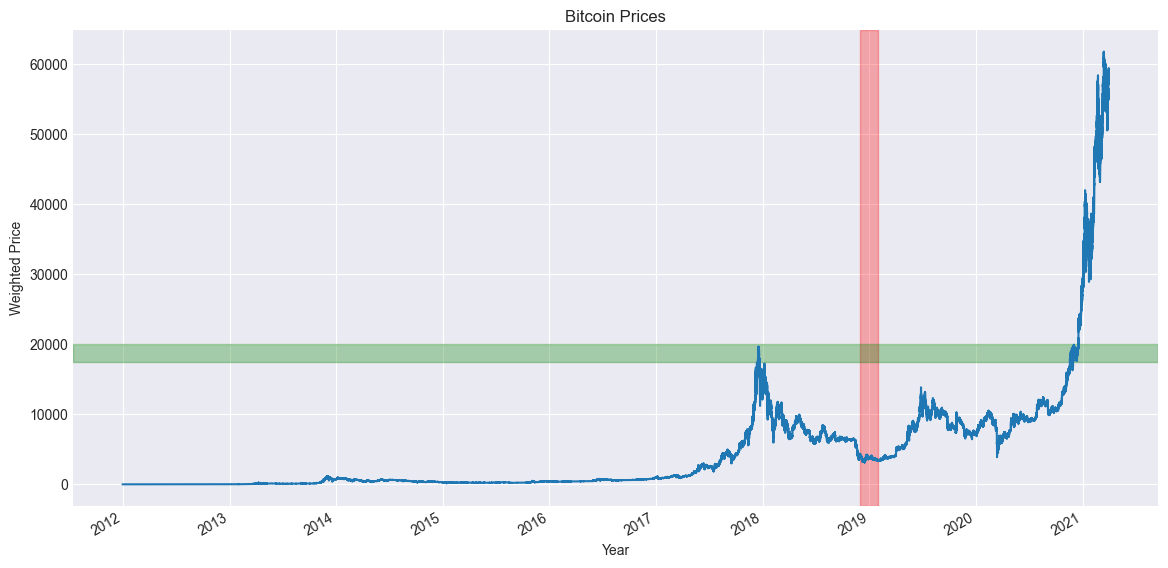

In [17]:
ax = bitstamp['Weighted_Price'].plot(title='Bitcoin Prices', grid=True, figsize=(14,7))
ax.set_xlabel('Year')
ax.set_ylabel('Weighted Price')

ax.axvspan('2018-12-01','2019-01-31',color='red', alpha=0.3)
ax.axhspan(17500,20000, color='green',alpha=0.3)

Text(0, 0.5, 'Weighted_Price')

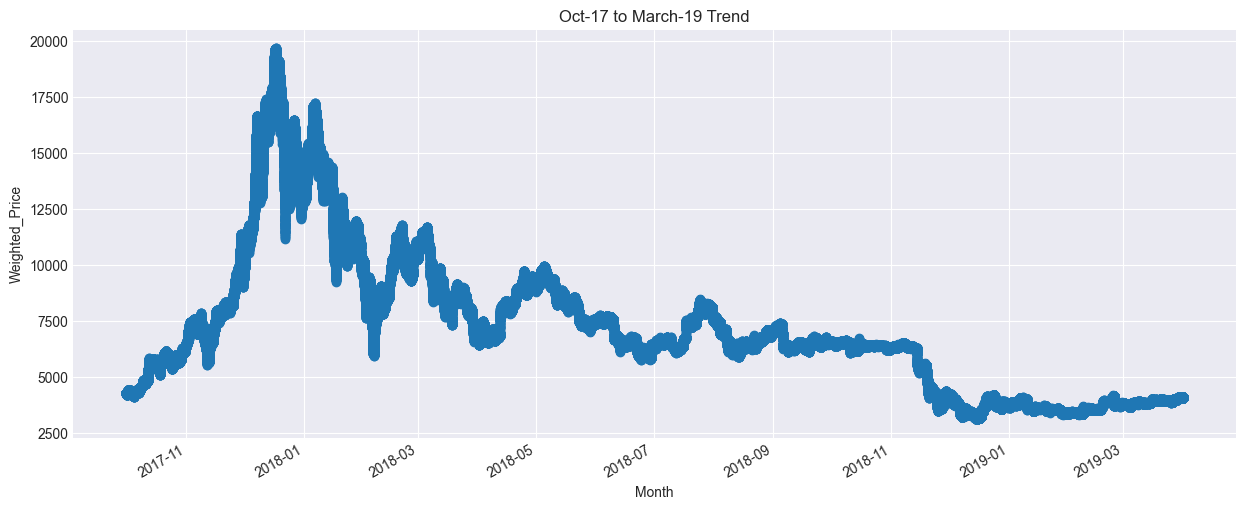

In [18]:
#Zooming in

ax = bitstamp.loc['2017-10':'2019-03','Weighted_Price'].plot(marker='o', linestyle='-',figsize=(15,6), title="Oct-17 to March-19 Trend", grid=True)
ax.set_xlabel('Month')
ax.set_ylabel('Weighted_Price')

There has been a increase in Bitcoin's weighted price except a slump in late 2018 and early 2019. Also, we can  observe a spike in weighted price in December 2017. We shall use Pandas to investigate it further in the coming sections.

# Visualising using KDEs

Summarizing the data with Density plots to see where the mass of the data is located.

/tmp/ipykernel_55519/2819362645.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(bitstamp['Weighted_Price'], shade=True)


<Axes: xlabel='Weighted_Price', ylabel='Density'>

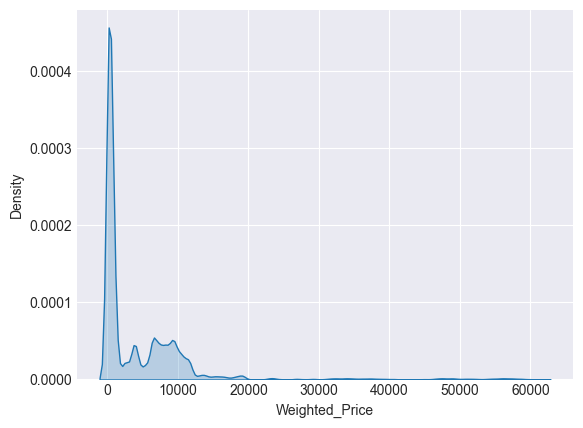

In [19]:
sns.kdeplot(bitstamp['Weighted_Price'], shade=True)

So there is a downward trend in stock prices from Dec-17 onwards till March 2019. We will investigate it further by investigation and with some findings during that period.

<a id="subsection-two"></a>

# Visualizing using Lag Plots

Lag plot are used to observe the autocorrelation. These are crucial when we try to correct the trend and stationarity and we have to use smoothing functions. Lag plot helps us to understand the data better.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


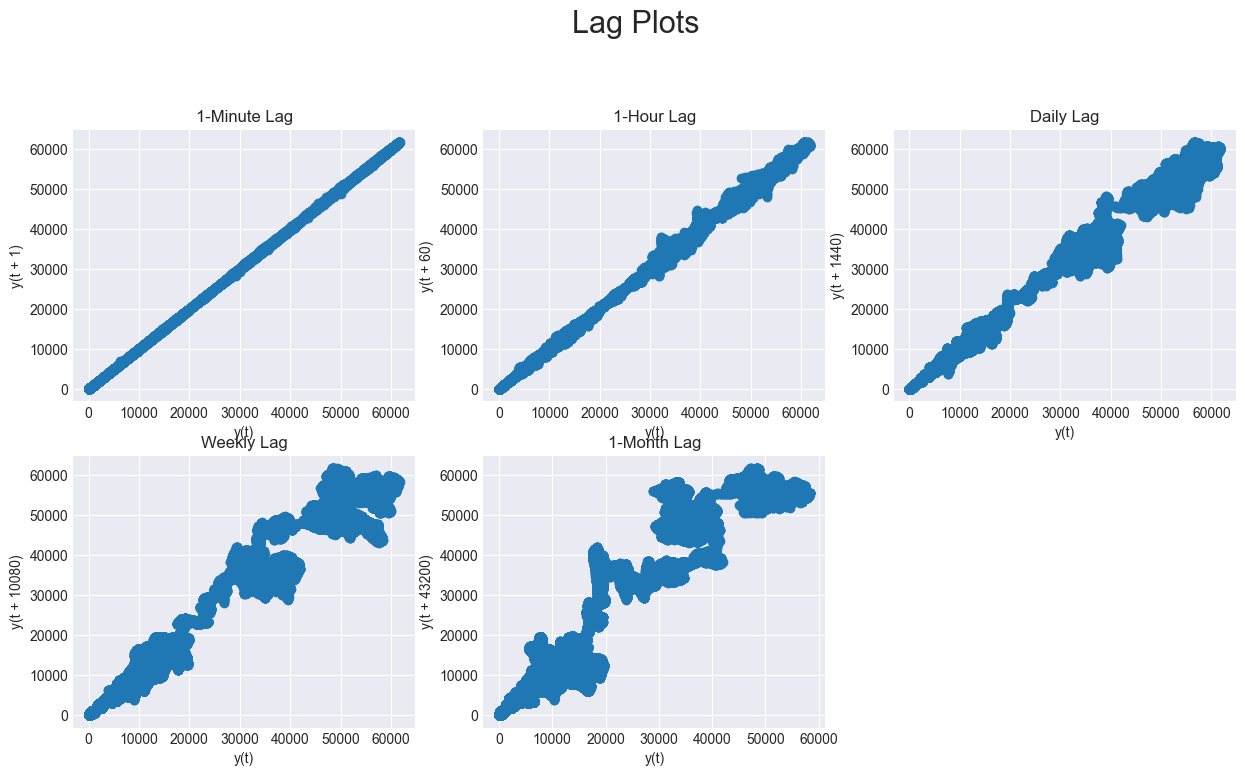

In [20]:
plt.figure(figsize=(15,12))
plt.suptitle('Lag Plots', fontsize=22)

plt.subplot(3,3,1)
pd.plotting.lag_plot(bitstamp['Weighted_Price'], lag=1) #minute lag
plt.title('1-Minute Lag')

plt.subplot(3,3,2)
pd.plotting.lag_plot(bitstamp['Weighted_Price'], lag=60) #hourley lag
plt.title('1-Hour Lag')

plt.subplot(3,3,3)
pd.plotting.lag_plot(bitstamp['Weighted_Price'], lag=1440) #Daily lag
plt.title('Daily Lag')

plt.subplot(3,3,4)
pd.plotting.lag_plot(bitstamp['Weighted_Price'], lag=10080) #weekly lag
plt.title('Weekly Lag')

plt.subplot(3,3,5)
pd.plotting.lag_plot(bitstamp['Weighted_Price'], lag=43200) #month lag
plt.title('1-Month Lag')

plt.legend()
plt.show()

We can see that there is a positive correlation for minute, hour and daily lag plots. We observe absolutely no correlation for month lag plots.

It makes sense to re-sample our data atmost at the Daily level, thereby preserving the autocorrelation as well. 

<a id="subsection-three"></a>

# Time resampling

Examining stock price data for every single day isn’t of much use to financial institutions, who are more interested in spotting market trends. To make it easier, we use a process called time resampling to aggregate data into a defined time period, such as by month or by quarter. Institutions can then see an overview of stock prices and make decisions according to these trends.

The pandas library has a .resample() function which resamples such time series data. The resample method in pandas is similar to its groupby method as it is essentially grouping according to a certain time span. The resample() function looks like this:

In [21]:
hourly_data = bitstamp.resample('1H').mean()
hourly_data = hourly_data.reset_index()

hourly_data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 02:00:00,4.39,4.39,4.39,4.39,0.803709,3.528285,4.39
1,2011-12-31 03:00:00,4.39,4.39,4.39,4.39,4.185530,18.374477,4.39
2,2011-12-31 04:00:00,4.39,4.39,4.39,4.39,10.153449,44.573640,4.39
3,2011-12-31 05:00:00,4.39,4.39,4.39,4.39,16.121368,70.772803,4.39
4,2011-12-31 06:00:00,4.39,4.39,4.39,4.39,22.089286,96.971967,4.39


**To summarize what happened above:**

* data.resample() is used to resample the stock data.
* The ‘1H’ stands for hourly frequency, and denotes the offset values by which we want to resample the data.
* mean() indicates that we want the average stock price during this period.

The offset values list can be found in the pandas [documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).

In [22]:
bitstamp_daily = bitstamp.resample("24H").mean() #daily resampling

# Plotting using Plotly

Plotly allows us to make interactve charts which are pretty useful in financial analysis. 

* The **range-sliders** can be used to zoom-in and zoom-out.
* The **range-selectors** can be used to select the range.

In [23]:
import plotly.express as px

bitstamp_daily.reset_index(inplace=True)
fig = px.line(bitstamp_daily, x='Timestamp', y='Weighted_Price', title='Weighted Price with Range Slider and Selectors')
fig.update_layout(hovermode="x")

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="backward"),
            dict(step="all")
            
        ])
    )
)
fig.show()

# Simple Candlestick Graph

In [24]:
plot_ = bitstamp_daily.set_index("Timestamp")["2017-12"]

/tmp/ipykernel_55519/1834295539.py:1: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



In [25]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Candlestick(x= plot_.index,
                    open=plot_['Open'],
                    high=plot_['High'],
                    low=plot_['Low'],
                    close=plot_['Close']))
fig.show()

<a id="section-four"></a>
# Time Series Decomposition & Statistical Tests

We can decompose a time series into trend, seasonal amd remainder components, as mentioned in the earlier section. The series can be decomposed as an additive or multiplicative combination of the base level, trend, seasonal index and the residual.
The seasonal_decompose in statsmodels is used to implements the decomposition.

We will then perform some statistical tests like [KPSS](http://en.wikipedia.org/wiki/KPSS_test) and [Augmented Dickey–Fuller](http://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) tests to check stationarity. 

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Let's ensure there are no missing values before you perform statistical tests.

In [27]:
fill_missing(bitstamp_daily)

   Timestamp      Open      High       Low     Close  Volume_(BTC)  \
0 2011-12-31  4.501211  4.503144  4.501211  4.503144     14.348397   
1 2012-01-01  4.852822  4.852822  4.852822  4.852822      8.647412   
2 2012-01-02  5.033860  5.033860  5.033860  5.033860     15.301089   
3 2012-01-03  5.177387  5.177387  5.177387  5.177387      6.007320   
4 2012-01-04  5.354507  5.395497  5.354507  5.395497     14.440415   

   Volume_(Currency)  Weighted_Price  
0          63.679063        4.501940  
1          42.493756        4.852822  
2          76.587357        5.033860  
3          31.187704        5.177387  
4          77.709541        5.369428  
Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64


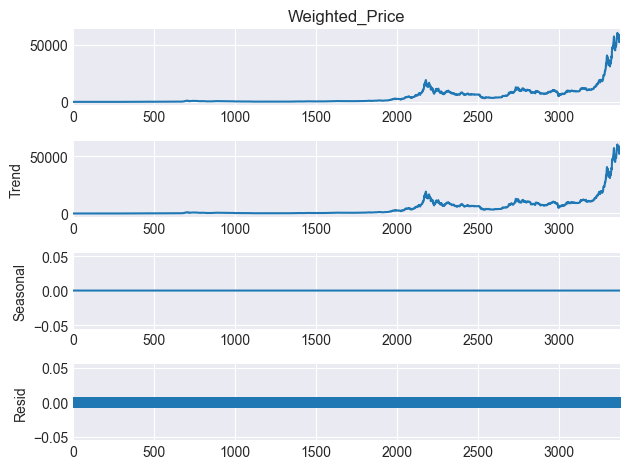

<Figure size 1500x1200 with 0 Axes>

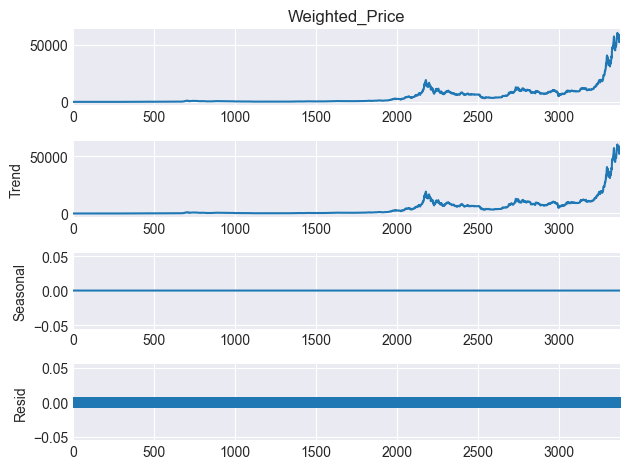

In [28]:
plt.figure(figsize=(15,12))
series = bitstamp_daily.Weighted_Price
result = seasonal_decompose(series, model='additive',period=1)
result.plot()

Post time series decomposition we don't observe any seasonality. Also, there is no constant mean, variance and covariance, hence the series is **Non Stationary.** 
We will perform statistical tests like KPSS and ADF to confirm our understanding.

But first, let's plot ACF and PACF graphs.

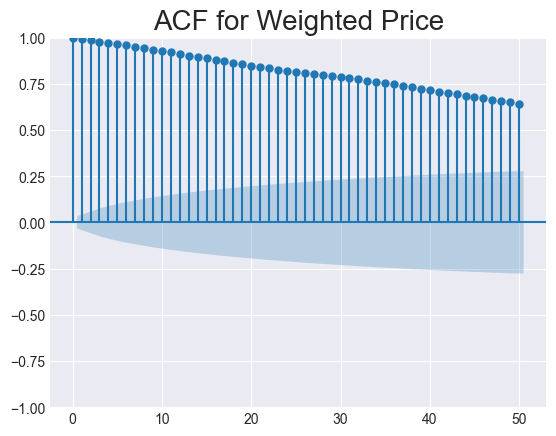

In [29]:
acf = plot_acf(series, lags=50, alpha=0.05)
plt.title("ACF for Weighted Price", size=20)
plt.show()

The above graph shows that effect barely detoriate over time, so past values affect the present ones. The more lags we include, the better our model will fit the dataset, now the risk is coefficients might predict the dataset too well, cause an overfitting.
In our model, we always try to include only those lags which have a direct effect on our present value. Hence, let's try PACF.

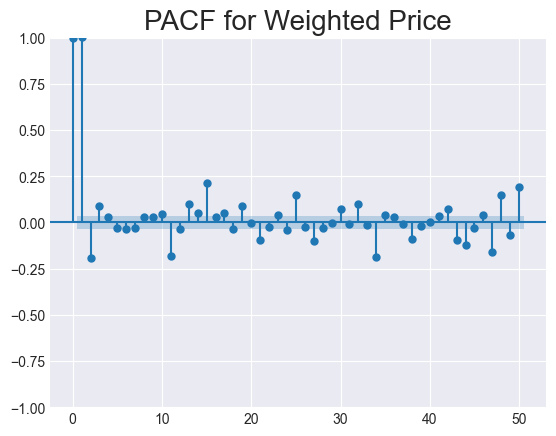

In [30]:
plot_pacf(series, lags=50, alpha=0.05, method='ols')
plt.title("PACF for Weighted Price", size=20)
plt.show()

Coefficients values for lag>5 are statistically not significant and their impact on the model is minimal, except a few spikes at 8,11,22 and beyond.

<a id="subsection-four"></a>
# KPSS Test

The KPSS test, short for, Kwiatkowski-Phillips-Schmidt-Shin (KPSS), is a type of Unit root test that tests for the stationarity of a given series around a deterministic trend.

Here, the null hypothesis is that the series is **stationary**.

That is, if p-value is < signif level (say 0.05), then the series is non-stationary and vice versa.

In [31]:
stats, p, lags, critical_values = kpss(series, 'ct')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




In [32]:
print(f'Test Statistics : {stats}')
print(f'p-value : {p}')
print(f'Critical Values : {critical_values}')

if p < 0.05:
    print('Series is not Stationary')
else:
    print('Series is Stationary')

Test Statistics : 0.6459308504076057
p-value : 0.01
Critical Values : {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is not Stationary


# Interpreting KPSS test results

The output of the KPSS test contains 4 things:

* The KPSS statistic
* p-value
* Number of lags used by the test
* Critical values

The **p-value** reported by the test is the probability score based on which you can decide whether to reject the null hypothesis or not. If the p-value is less than a predefined alpha level (typically 0.05), we reject the null hypothesis.

The **KPSS statistic** is the actual test statistic that is computed while performing the test.

The number of **lags** reported is the number of lags of the series that was actually used by the model equation of the kpss test.

In order to reject the null hypothesis, the test statistic should be greater than the provided critical values. If it is in fact higher than the target critical value, then that should automatically reflect in a low p-value.
That is, if the p-value is less than 0.05, the kpss statistic will be greater than the 5% critical value.

<a id="subsection-five"></a>
# ADF Test

The only difference here is the Null hypothesis which is just opposite of KPSS.

The null hypothesis of the test is the presence of **unit root**, that is, the series is **non-stationary**.

In [33]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    
    print (dfoutput)
    
    if p > 0.05:
        print('Series is not Stationary')
    else:
        print('Series is Stationary')

In [34]:
adf_test(series)

Results of Dickey-Fuller Test:
Test Statistic                    6.084514
p-value                           1.000000
#Lags Used                       29.000000
Number of Observations Used    3348.000000
Critical Value (1%)              -3.432305
Critical Value (5%)              -2.862404
Critical Value (10%)             -2.567230
dtype: float64
Series is Stationary


# Conclusion


KPSS says series is not stationary and ADF says series is stationary. It means series is **difference stationary**, we will use **differencing** to make series stationary.

<a id="section-five"></a>
# Feature Extraction

# Rolling windows

Time series data can be noisy due to high fluctuations in the market. As a result, it becomes difficult to gauge a trend or pattern in the data. 

As we’re looking at daily data, there’s quite a bit of noise present. It would be nice if we could average this out by a week, which is where a rolling mean comes in. 

A rolling mean, or moving average, is a transformation method which helps average out noise from data. It works by simply splitting and aggregating the data into windows according to function, such as mean(), median(), count(), etc. For this example, we’ll use a rolling mean for 3, 7 and 30 days.

In [35]:
df = bitstamp_daily.set_index("Timestamp")

In [36]:
df.reset_index(drop=False, inplace=True)

lag_features = ["Open", "High", "Low", "Close","Volume_(BTC)"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index()
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index()
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index()

df_std_3d = df_rolled_3d.std().shift(1).reset_index()
df_std_7d = df_rolled_7d.std().shift(1).reset_index()
df_std_30d = df_rolled_30d.std().shift(1).reset_index()

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("Timestamp", drop=False, inplace=True)
df.head()

/tmp/ipykernel_55519/3198738075.py:29: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Open_mean_lag3,Open_mean_lag7,...,Close_mean_lag30,Close_std_lag3,Close_std_lag7,Close_std_lag30,Volume_(BTC)_mean_lag3,Volume_(BTC)_mean_lag7,Volume_(BTC)_mean_lag30,Volume_(BTC)_std_lag3,Volume_(BTC)_std_lag7,Volume_(BTC)_std_lag30
Timestamp,,,,,,,,,,,,,,,,,,,,,
2011-12-31,2011-12-31,4.501211,4.503144,4.501211,4.503144,14.348397,63.679063,4.501940,4556.446488,4524.022138,...,4334.223840,112.256503,184.925053,416.831670,9.570695,9.576111,9.589786,3.369535,4.128381,5.112521
2012-01-01,2012-01-01,4.852822,4.852822,4.852822,4.852822,8.647412,42.493756,4.852822,4.501211,4.501211,...,4.503144,112.256503,184.925053,416.831670,14.348397,14.348397,14.348397,3.369535,4.128381,5.112521
2012-01-02,2012-01-02,5.033860,5.033860,5.033860,5.033860,15.301089,76.587357,5.033860,4.677017,4.677017,...,4.677983,0.247260,0.247260,0.247260,11.497905,11.497905,11.497905,4.031206,4.031206,4.031206
2012-01-03,2012-01-03,5.177387,5.177387,5.177387,5.177387,6.007320,31.187704,5.177387,4.795965,4.795965,...,4.796609,0.269787,0.269787,0.269787,12.765633,12.765633,12.765633,3.598154,3.598154,3.598154
2012-01-04,2012-01-04,5.354507,5.395497,5.354507,5.395497,14.440415,77.709541,5.369428,5.021356,4.891320,...,4.891803,0.162643,0.291155,0.291155,9.985274,11.076055,11.076055,4.789148,4.477705,4.477705


**Benefits :**

So, what are the key benefits of calculating a moving average or using this rolling mean method? Our data becomes a lot less noisy and more reflective of the trend than the data itself.

Let's extract time and date features from the Date column.

In [37]:
df["month"] = df.Timestamp.dt.month
df["week"] = df.Timestamp.dt.week
df["day"] = df.Timestamp.dt.day
df["day_of_week"] = df.Timestamp.dt.dayofweek
df.head()

/tmp/ipykernel_55519/3147969711.py:2: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.



,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Open_mean_lag3,Open_mean_lag7,...,Volume_(BTC)_mean_lag3,Volume_(BTC)_mean_lag7,Volume_(BTC)_mean_lag30,Volume_(BTC)_std_lag3,Volume_(BTC)_std_lag7,Volume_(BTC)_std_lag30,month,week,day,day_of_week
Timestamp,,,,,,,,,,,,,,,,,,,,,
2011-12-31,2011-12-31,4.501211,4.503144,4.501211,4.503144,14.348397,63.679063,4.501940,4556.446488,4524.022138,...,9.570695,9.576111,9.589786,3.369535,4.128381,5.112521,12,52,31,5
2012-01-01,2012-01-01,4.852822,4.852822,4.852822,4.852822,8.647412,42.493756,4.852822,4.501211,4.501211,...,14.348397,14.348397,14.348397,3.369535,4.128381,5.112521,1,52,1,6
2012-01-02,2012-01-02,5.033860,5.033860,5.033860,5.033860,15.301089,76.587357,5.033860,4.677017,4.677017,...,11.497905,11.497905,11.497905,4.031206,4.031206,4.031206,1,1,2,0
2012-01-03,2012-01-03,5.177387,5.177387,5.177387,5.177387,6.007320,31.187704,5.177387,4.795965,4.795965,...,12.765633,12.765633,12.765633,3.598154,3.598154,3.598154,1,1,3,1
2012-01-04,2012-01-04,5.354507,5.395497,5.354507,5.395497,14.440415,77.709541,5.369428,5.021356,4.891320,...,9.985274,11.076055,11.076055,4.789148,4.477705,4.477705,1,1,4,2


<a id="section-six"></a>
# Model Building

# Important Note on Cross Validation

To measure the performance of our forecasting model, We typically want to split the time series into a training period and a validation period. This is called fixed partitioning. 

* If the time series has some seasonality, you generally want to ensure that each period contains a whole number of seasons. For example, one year, or two years, or three years, if the time series has a yearly seasonality. 
You generally don't want one year and a half, or else some months will be represented more than others. 
 
* We'll train our model on the training period, we'll evaluate it on the validation period. Here's where you can experiment to find the right architecture for training. And work on it and your hyper parameters, until you get the desired performance, measured using the validation set. Often, once you've done that, you can retrain using both the training and validation data.And then test on the test(or forecast) period to see if your model will perform just as well.
 
* And if it does, then you could take the unusual step of retraining again, using also the test data. But why would you do that? Well, it's because the test data is the closest data you have to the current point in time. And as such it's often the strongest signal in determining future values. If your model is not trained using that data, too, then it may not be optimal.

Here, we we will opt for a ***hold-out based validation***. 

Hold-out is used very frequently with time-series data. In this case, we will select all the data for 2020 as a hold-out and train our model on all the data from 2012 to 2019. 


In [38]:
df_train = df[df.Timestamp < "2020"]
df_valid = df[df.Timestamp >= "2020"]

print('train shape :', df_train.shape)
print('validation shape :', df_valid.shape)

train shape : (2923, 42)
validation shape : (455, 42)


<a id="subsection-eight"></a>
# XG Boost

In [39]:
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

from datetime import datetime

Here, we we will opt for a ***hold-out based validation***. 

Hold-out is used very frequently with time-series data. In this case, we will select all the data for 2020 as a hold-out and train our model on all the data from 2012 to 2019. 

In [42]:
exogenous_features = ['Open_mean_lag3',
       'Open_mean_lag7', 'Open_mean_lag30', 'Open_std_lag3', 'Open_std_lag7',
       'Open_std_lag30', 'High_mean_lag3', 'High_mean_lag7', 'High_mean_lag30',
       'High_std_lag3', 'High_std_lag7', 'High_std_lag30', 'Low_mean_lag3',
       'Low_mean_lag7', 'Low_mean_lag30', 'Low_std_lag3', 'Low_std_lag7',
       'Low_std_lag30', 'Close_mean_lag3', 'Close_mean_lag7',
       'Close_mean_lag30', 'Close_std_lag3', 'Close_std_lag7',
       'Close_std_lag30', 'Volume_(BTC)_mean_lag3', 'Volume_(BTC)_mean_lag7',
       'Volume_(BTC)_mean_lag30', 'Volume_(BTC)_std_lag3',
       'Volume_(BTC)_std_lag7', 'Volume_(BTC)_std_lag30', 'month', 'week',
       'day', 'day_of_week']

In [43]:
X_train, y_train = df_train[exogenous_features], df_train.Weighted_Price
X_test, y_test = df_valid[exogenous_features], df_valid.Weighted_Price

In [44]:
reg = xgb.XGBRegressor()

In [45]:
## Hyper Parameter Optimization Grid

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 "max_depth"        : [1, 3, 4, 5, 6, 7],
 "n_estimators"     : [int(x) for x in np.linspace(start=100, stop=2000, num=10)],
 "min_child_weight" : [int(x) for x in np.arange(3, 15, 1)],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "subsample"        : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bytree" : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bylevel": [0.5, 0.6, 0.7, 0.8, 0.9, 1],  
 
}

In [46]:
model  = RandomizedSearchCV(    
                reg,
                param_distributions=params,
                n_iter=10,
                n_jobs=-1,
                cv=5,
                verbose=3,
)

In [47]:
model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END colsample_bylevel=0.6, colsample_bytree=0.8, gamma=0.9, learning_rate=0.2, max_depth=6, min_child_weight=12, n_estimators=311, subsample=0.5;, score=-22.810 total time=   1.9s
[CV 4/5] END colsample_bylevel=0.6, colsample_bytree=0.8, gamma=0.9, learning_rate=0.2, max_depth=6, min_child_weight=12, n_estimators=311, subsample=0.5;, score=0.915 total time=   1.9s
[CV 2/5] END colsample_bylevel=0.6, colsample_bytree=0.8, gamma=0.9, learning_rate=0.2, max_depth=6, min_child_weight=12, n_estimators=311, subsample=0.5;, score=0.946 total time=   1.9s
[CV 3/5] END colsample_bylevel=0.6, colsample_bytree=0.8, gamma=0.9, learning_rate=0.2, max_depth=6, min_child_weight=12, n_estimators=311, subsample=0.5;, score=0.945 total time=   1.9s
[CV 5/5] END colsample_bylevel=0.6, colsample_bytree=0.8, gamma=0.9, learning_rate=0.2, max_depth=6, min_child_weight=12, n_estimators=311, subsample=0.5;, score=0.943 total time=   2.0s
[C

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                                              0.8, 0.9, 1],
                                        'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             0.9, 1],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                  0.6, 0.7, 0.8, 0.9, 1],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [1, 3, 4, 5, 6, 7],
                                        'min_child_weight': [3, 4, 5, 6, 7, 8,
                                                             9, 10, 11, 12, 13,
                                                             14],
                                        'n_estimators': [100, 311, 522, 733,
                                                         944, 1155, 1366, 1577,
                                                         1788, 2000],
                                        'subsample': [0.1, 0.2, 0.3, 0.4, 0.5,
                                                      0.6, 0.7, 0.8, 0.9, 1]},
                   verbose=3)

In [48]:
print(f"Model Best Score : {model.best_score_}")
print(f"Model Best Parameters : {model.best_estimator_.get_params()}")

Model Best Score : -3.451622227608606
Model Best Parameters : {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.3, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.25, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 7, 'max_leaves': None, 'min_child_weight': 8, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 1577, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [49]:
model.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None, colsample_bylevel=1,
             colsample_bynode=None, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.3, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.25, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             n_estimators=1577, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

/tmp/ipykernel_55519/3944082182.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='Timestamp'>

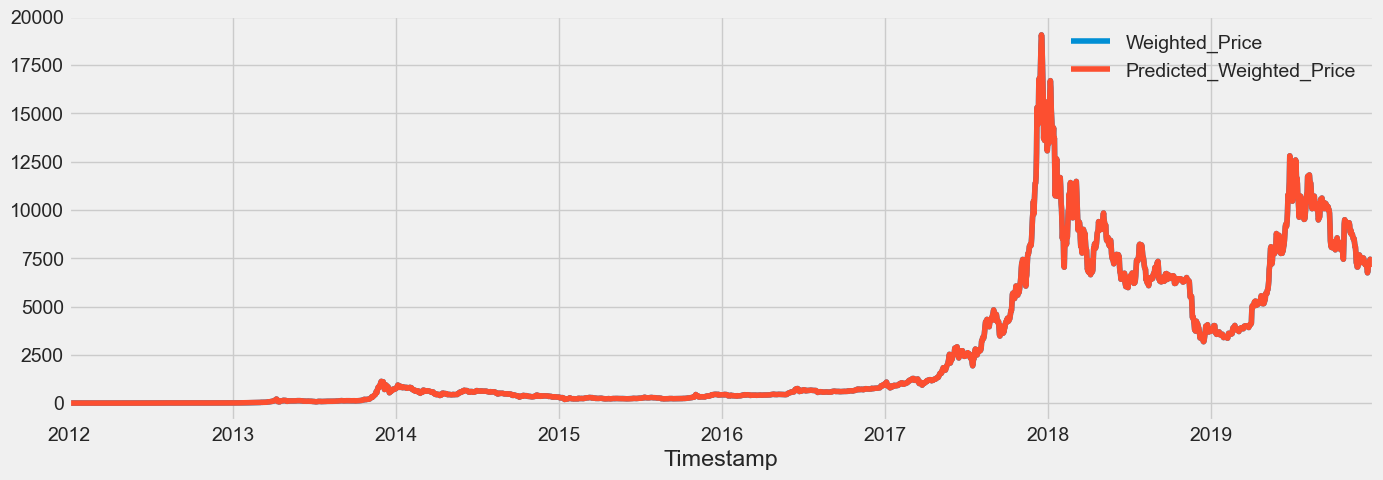

In [50]:
df_train['Predicted_Weighted_Price'] = model.predict(X_train)

df_train[['Weighted_Price','Predicted_Weighted_Price']].plot(figsize=(15, 5))

In [51]:
df_valid['Forecast_XGBoost'] = model.predict(X_test)

overall_data = pd.concat([df_train, df_valid], sort=False)

/tmp/ipykernel_55519/390820625.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='Timestamp'>

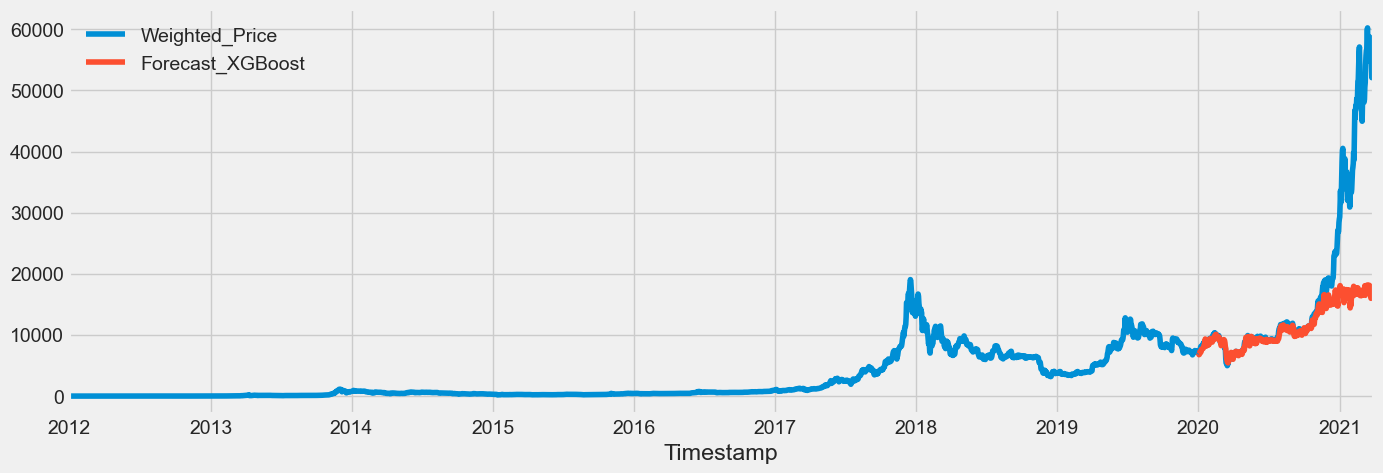

In [52]:
overall_data[['Weighted_Price','Forecast_XGBoost']].plot(figsize=(15, 5))

<Axes: xlabel='Timestamp'>

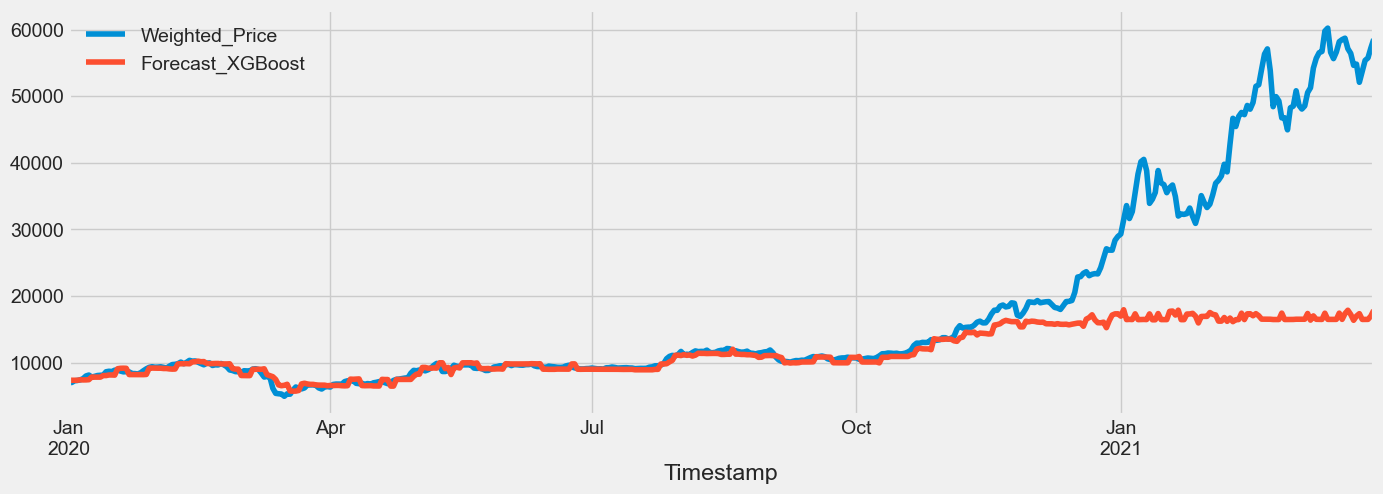

In [ ]:
df_valid[['Weighted_Price','Forecast_XGBoost']].plot(figsize=(15, 5))

In [57]:
df_valid['Forecast_XGBoost'].to_csv('forecast.csv', header=None)